## Rebound Rate Analysis 

### Overview  
This notebook analyzes the Rebound Rate (REB%) for Partizan Mozzart Bet Belgrade players during the 2022-2023 EuroLeague season. Rebound Rate (REB%) estimates the percentage of available team rebounds a player secures while on the court, adjusted for playing time. It’s a simplified version of the true REB% (which uses total available rebounds - team + opponent) and I use team rebound as proxy, because of data.  The analysis uses the cleaned dataset `partizan_2022_cleaned.csv` and includes:  

- Loading and filtering the dataset.  
- Calculating per-game REB% and identifying top performers.  
- Validating the calculation for a specific player.  
- Visualizing results with a bar plot.  
- Comparing regular season and playoff performance.

In [10]:
import pandas as pd

file_path = "../data/partizan_2022_cleaned.csv"

df = pd.read_csv(file_path)

Separate player-specific data from team totals to focus on individual REB% calculations.

In [2]:
# filter 
players = df[df['player'] != 'PARTIZAN MOZZART BET BELGRADE'].copy()
team = df[df['player'] == 'PARTIZAN MOZZART BET BELGRADE'].copy()

Compute the per-game REB% for each player to assess their rebounding efficiency, adjusted for playing time.

### Formula  
REB% = 100 × (Player Total Rebounds / Team Total Rebounds) × (Player Total Seconds / Game Seconds)

In [ ]:
# calculate Rebound Rate
# formula: Rebound Rate = 100 * (Player Total Rebounds / Team Total Rebounds) * (Player Total Seconds / game_seconds)
# Rebound Rate (REB%): Percentage of team rebounds secured, adjusted for playing time
# approximates rebounding impact using team totals as a proxy for available rebounds.

# merge team stats to players 
players = players.merge(team[['game', 'total_rebounds']], on='game', suffixes=('', '_team'))

# reset index to avoid duplicate labels
players = players.reset_index(drop=True)


# calculate Rebound Rate
game_seconds = 2400  # 40 minutes * 60 seconds
players['rebound_rate'] = 100 * (players['total_rebounds'] / players['total_rebounds_team']) * (players['total_seconds'] / game_seconds)


# handle division by zero (players with no team stats)
players['rebound_rate'] = players['rebound_rate'].fillna(0).replace([float('inf'), -float('inf')], 0)

# average Rebound Rate per player
avg_rr = players.groupby('player')['rebound_rate'].mean().sort_values(ascending=False)

print("Top 5 Players by Rebound Rate:") 
print(avg_rr.head(5))

Top 5 Players by Rebound Rate:
player
Lessort Mathias    16.606726
Leday Zach         12.978675
Punter Kevin        5.821043
Nunnally James      4.828153
Exum Dante          4.804690
Name: rebound_rate, dtype: float64


Mathias Lessort leads with a REB% of 16.61, followed by Zach Leday at 12.98, highlighting their dominance on the boards.

Generate a bar plot to visualize the REB%.

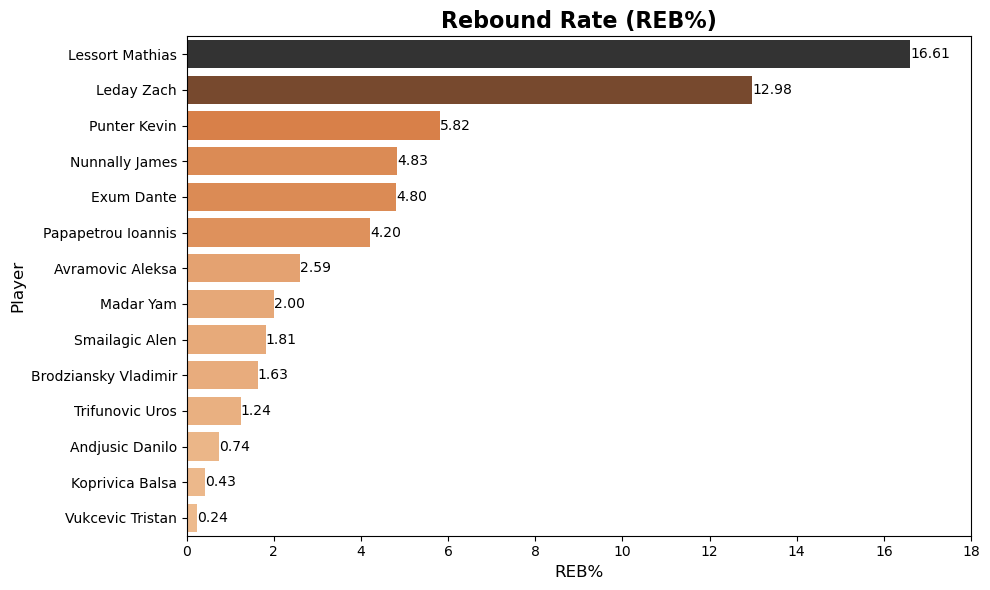

In [9]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns


top_rr = avg_rr.head(14)

# plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_rr.values, y=top_rr.index, hue=top_rr.values, palette='Oranges_d', legend=False)
plt.title('Rebound Rate (REB%)', fontsize=16, fontweight='bold')
plt.xlabel('REB%', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.xlim(0, 18)  


for i, v in enumerate(top_rr.values):
    ax.text(v, i, f'{v:.2f}', va='center', ha='left', fontsize=10)


plt.tight_layout()
plt.show()

A horizontal bar plot displays players by REB%, with Mathias Lessort at 16.61 and Zach Leday at 12.98 leading. The orange palette and annotated values (e.g., 16.61) enhance readability.

Verify the REB% calculation for Mathias Lessort by comparing the computed per-game average with a manual calculation from raw averages.

In [4]:
# check: Validate specific player's Rebound Rate calculation
player_to_check = 'Lessort Mathias'
check_player = players[players['player'] == player_to_check]
raw_means = check_player[['total_rebounds', 'total_seconds', 'total_rebounds_team']].mean()
computed_reb = check_player['rebound_rate'].mean()


# manual calculation from averages
manual_reb = 100 * (raw_means['total_rebounds'] / raw_means['total_rebounds_team']) * (raw_means['total_seconds'] / game_seconds) if raw_means['total_rebounds_team'] > 0 else 0



print(f"\nCheck for {player_to_check}:")
print(f"Computed REB% (mean of per-game values): {computed_reb:.4f}")
print(f"Manual REB% (from averaged stats): {manual_reb:.4f}")
print(f"Raw Averages - Player Rebounds: {raw_means['total_rebounds']:.2f}, Seconds: {raw_means['total_seconds']:.2f}, "
      f"Team Rebounds: {raw_means['total_rebounds_team']:.2f}")


Check for Lessort Mathias:
Computed REB% (mean of per-game values): 16.6067
Manual REB% (from averaged stats): 15.8581
Raw Averages - Player Rebounds: 6.46, Seconds: 1743.76, Team Rebounds: 29.61


### Validation for Rebound Rate (REB%)  

#### Summary  
The computed REB% (16.61) differs from the manual calculation (15.86) because the per-game average emphasizes standout performances, while the manual method smooths totals. This validates the method’s focus on game-by-game rebounding prowess.

#### Additional Explanation  
Computed REB% (16.61) averages per-game values, emphasizing standout performances, while manual REB% (15.86) uses season averages for a smoothed total. The per-game averaging method was chosen for consistency with other metrics, highlighting game-by-game rebounding prowess.

Compare REB% between regular season and playoffs to identify players who improve their rebounding in high-pressure games.

In [ ]:
# compering regular season and playoffs
# split into regular season and playoffs for players and team
regular_players = players[players['phase'] == 'REGULAR SEASON'].copy()
playoff_players = players[players['phase'] == 'PLAYOFFS'].copy()
regular_team = team[team['phase'] == 'REGULAR SEASON'].drop_duplicates(subset='game').copy()
playoff_team = team[team['phase'] == 'PLAYOFFS'].drop_duplicates(subset='game').copy()

# function to calculate REB% for a phase
def calculate_reb_rate(players_df, team_df):
    # drop existing team columns to avoid duplication
    players_df = players_df.drop(columns=['total_rebounds_team'], errors='ignore')
    
    # merge with team rebounds for the phase
    merged = players_df.merge(
        team_df[['game', 'total_rebounds']], 
        on='game', 
        suffixes=('', '_team')
    )
    
    # calculate REB% using phase-specific team stats
    merged['rebound_rate'] = 100 * (merged['total_rebounds'] / merged['total_rebounds_team']) * (merged['total_seconds'] / 2400)
    
    # handle division errors
    merged['rebound_rate'] = merged['rebound_rate'].replace([float('inf'), -float('inf')], 0).fillna(0)
    return merged

# recalculate REB% for both phases
regular_recalc = calculate_reb_rate(regular_players, regular_team)
playoff_recalc = calculate_reb_rate(playoff_players, playoff_team)

# average REB% per player in each phase
reg_avg = regular_recalc.groupby('player')['rebound_rate'].mean()
play_avg = playoff_recalc.groupby('player')['rebound_rate'].mean()

# combine results
combined = reg_avg.to_frame('reb_reg').join(play_avg.to_frame('reb_play'), how='outer').fillna(0)
combined['reb_diff'] = combined['reb_play'] - combined['reb_reg']



print("Top 5 Players by REB% Improvement (Playoffs - Regular Season):")
print(combined.sort_values('reb_diff', ascending=False).head(5))

Top 5 Players by REB% Improvement (Playoffs - Regular Season):
                   reb_reg   reb_play  reb_diff
player                                         
Madar Yam         1.059086   4.083803  3.024716
Nunnally James    4.413308   5.990741  1.577433
Trifunovic Uros   1.019418   1.712782  0.693364
Leday Zach       13.153645  13.200877  0.047231
Punter Kevin      5.964064   6.007440  0.043376


Yam Madar shows the largest REB% increase (3.02), followed by James Nunnally (1.58), indicating significant improvement in rebounding during the playoffs.

Validate Yam Madar’s REB% in regular season and playoffs using per-game averages versus raw totals.

In [6]:
# check specific player's REB% in Regular Season and Playoffs
def check_rebound_rate(player_name, regular_data, playoff_data):
    game_seconds = 2400  # 40 minutes * 60 seconds
    
    for phase_name, phase_df in [('Regular Season', regular_data),
                                 ('Playoffs', playoff_data)]:
        # get player data for the phase
        player_data = phase_df[phase_df['player'] == player_name]
        
        if player_data.empty:
            print(f"\n{player_name} has no games in {phase_name}")
            continue
            
        # get computed average
        computed_reb = player_data['rebound_rate'].mean()
        
        # get raw averages for manual calculation
        raw_means = player_data[['total_rebounds', 'total_rebounds_team', 'total_seconds']].mean()
        
        # ganual calculation from averages
        manual_reb = 100 * (raw_means['total_rebounds'] / raw_means['total_rebounds_team']) * \
                     (raw_means['total_seconds'] / game_seconds) if raw_means['total_rebounds_team'] > 0 else 0
        
        
        print(f"\nCheck for {player_name} - {phase_name}:")
        print(f"Computed REB% (mean): {computed_reb:.4f}")
        print(f"Manual REB% (from averages): {manual_reb:.4f}")
        print(f"Raw Averages - Player Reb: {raw_means['total_rebounds']:.2f}, "
              f"Team Reb: {raw_means['total_rebounds_team']:.2f}, "
              f"Seconds: {raw_means['total_seconds']:.2f}")



player_to_check = 'Madar Yam'
check_rebound_rate(player_to_check, regular_recalc, playoff_recalc)


Check for Madar Yam - Regular Season:
Computed REB% (mean): 1.0591
Manual REB% (from averages): 0.7871
Raw Averages - Player Reb: 0.79, Team Reb: 29.56, Seconds: 702.56

Check for Madar Yam - Playoffs:
Computed REB% (mean): 4.0838
Manual REB% (from averages): 3.6933
Raw Averages - Player Reb: 2.72, Team Reb: 29.00, Seconds: 944.28


The computed values (1.06 and 4.08) differ from manual calculations (0.79 and 3.69) due to the per-game averaging method, which emphasizes standout performances, while the manual method smooths totals. This confirms the analysis prioritizes game-by-game rebounding impact.

### Conclusion  
This analysis:  

- Identified **Mathias Lessort** as the top REB% performer (16.61 overall), followed by **Zach Leday** (12.98), showcasing their rebounding dominance.  
- Confirmed calculation accuracy through validation, noting differences between per-game averages (e.g., 16.61 for Lessort) and total-based methods (e.g., 15.86), with per-game averaging chosen to highlight game-by-game prowess.  
- Visualized players effectively, with Lessort and Leday leading.  
- Highlighted **Yam Madar**’s 3.02-point REB% increase in playoffs, followed by **James Nunnally** (1.58), indicating significant improvement in rebounding under pressure.  

These insights can guide coaching decisions, such as relying on Madar or Nunnally for rebounding in playoff scenarios.